In [3]:
%pip install dowhy
%apt install libgraphviz-dev
%pip install pygraphviz
%pip install pandas

You should consider upgrading via the '/home/natalia/wsi/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%apt` not found.


In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

df = pd.read_csv(url)

print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [13]:
from dowhy import CausalModel
import dowhy.datasets

df_subset = df[["Survived", "Pclass", "Sex", "Age","SibSp", "Parch","Fare"]]
df_cleaned = df_subset.dropna(subset=["Survived", "Pclass", "Sex", "Age","SibSp", "Parch","Fare"], how='any')


model = CausalModel(
    data=df_cleaned,
    treatment='Age',
    outcome='Survived',
    common_causes=['Pclass', 'Sex'])

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
──────(E[Survived|Sex,Pclass])
d[Age]                        
Estimand assumption 1, Unconfoundedness: If U→{Age} and U→Survived then P(Survived|Age,Sex,Pclass,U) = P(Survived|Age,Sex,Pclass)

## Realized estimand
b: Survived~Age+Sex+Pclass
Target units: ate

## Estimate
Mean value: -0.005945899137966393



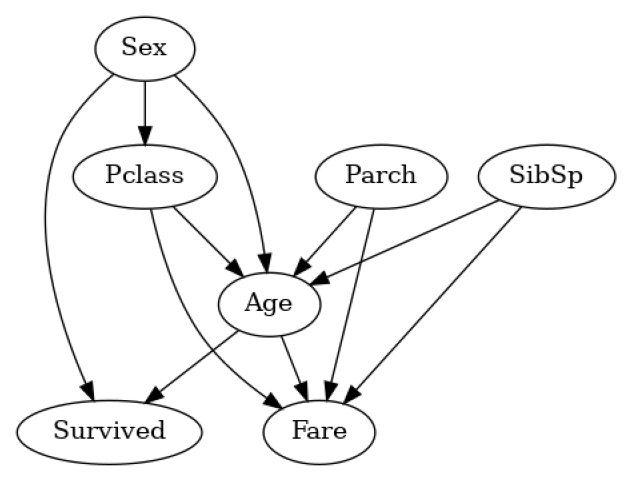

In [14]:
import pandas as pd
import dowhy
from dowhy import CausalModel
from sklearn.preprocessing import LabelEncoder
import numpy as np

non_numeric_columns = list(df.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    df[col] = le.fit_transform(df[col])

df.dropna(inplace=True)


model = CausalModel(
    data=df,
    treatment='Age',
    outcome='Survived',
    graph="""strict digraph  {
        Survived;
        Pclass;
        Sex;
        Age;
        SibSp;
        Parch;
        Fare;
        Pclass -> Age  [origin=learned, weight="5.416071829739479"];
        Pclass -> Fare  [origin=learned, weight="-14.25094835798153"];
        Sex -> Pclass  [origin=learned, weight="1.9612868992525074"];
        Sex -> Age  [origin=learned, weight="15.093280533019355"];
        Sex -> Survived  [origin=unknown];
        Age -> Fare  [origin=learned, weight="0.8868948035637376"];
        Age -> Survived  [origin=unknown];
        SibSp -> Age  [origin=learned, weight="-2.3941882023445102"];
        SibSp -> Fare  [origin=learned, weight="11.379387128775761"];
        Parch -> Age  [origin=learned, weight="1.272125513706115"];
        Parch -> Fare  [origin=learned, weight="13.65133594895557"];
        }"""
)

model.view_model(layout="dot")


In [11]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
──────(E[Survived|Sex])
d[Age]                 
Estimand assumption 1, Unconfoundedness: If U→{Age} and U→Survived then P(Survived|Age,Sex,U) = P(Survived|Age,Sex)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                  -1⎤
 ⎢       d                  ⎛       d              ⎞  ⎥
E⎢───────────────(Survived)⋅⎜───────────────([Age])⎟  ⎥
 ⎣d[SibSp  Parch]           ⎝d[SibSp  Parch]       ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Survived then ¬(U →→{SibSp,Parch})
Estimand assumption 2, Exclusion: If we remove {SibSp,Parch}→{Age}, then ¬({SibSp,Parch}→Survived)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

